In [43]:
%%time
# cell for memory management
# run it to see the memory which each variable is using and delete them
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

           transactions_merged: 42.5 GiB
                  transactions:  7.1 GiB
                     customers: 512.9 MiB
                  gender_score: 167.6 MiB
                      articles: 118.4 MiB
                           ___: 14.0 KiB
                           _22: 14.0 KiB
                            __:  6.9 KiB
                           _24:  6.9 KiB
                           _20:  6.1 KiB
Wall time: 56.3 s


# Exploratory Data Analysis: H&M Transaction Data

H&M (Hennes & Mauritz AB) is a Swedish multinational clothing company headquartered in Stockholm. Its  focus is fast-fashion clothing for men, women, teenagers and childern. Its market capitalization is 20.68 billion USD and it has more than 5,000 stores around 74 countries. As an international fast-fashion brand, it product portfolio serves the diverse needs of customers all around the world. Thus, it faces a challenge of recommending proper items to each customer. \
In this notebook, I will conduct exploratory data anlysis of H&M's customers, articles, and transactions data to better understand the data and get insights for further analysis.

## 0. Load data and libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from matplotlib import pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots

In [2]:
# Custom functions
def df_summary(df):
    """
    provide brief information about a dataframe
    """
    assert isinstance(df, pd.DataFrame)
    print('===the first rows===')
    display(df.head())
    print(f'The shape of the dataset:{df.shape}')
    print(f'The features of the dataset:{list(df.columns)}')
    print(f'{df.isnull().any().sum()} features have missing values')
    print(f'{(df.apply(lambda x: x.nunique()) == 1).sum()} features have one unique value')
    
def df_unique(df,cutoff=100):
    """
    print unique values for each column
    cutoff: a limit to skip a column with too many unique values
    """
    print("=======Unique values of each column=======")
    for col in df.columns:
        print(f"==={col} Column===")
        vals = df[col].unique()
        if len(vals) > cutoff:
            print(f"There are {len(vals)} unique vales. Only showing limited number of examples.\n{vals[0:10]}")
        else:
            print(vals)    

def reduce_mem_usage(df):
    # From kernel https://www.kaggle.com/gemartin/load-data-reduce-memory-usage , modified by Minseok Song
    # WARNING! THIS CAN DAMAGE THE DATA 
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type not in [object,'<M8[ns]']: # added datetime dtype
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
# loda data
data_path = Path("../data")
articles = pd.read_csv(data_path /"articles.csv")
customers = pd.read_csv(data_path /"customers.csv")
transactions = pd.read_csv(data_path /"transactions_train.csv")

## 0.1 Data Pre-processing

### 0.1.1 NA values handling

In [4]:
# handling NA values
customers['FN'].fillna(0, inplace=True)
customers['Active'].fillna(0, inplace=True)
customers['club_member_status'].fillna('NOT MEMBER',inplace=True)
customers['fashion_news_frequency'].replace(dict.fromkeys([np.nan,'None'],'NONE'),inplace=True)
# customers['age'].fillna(int(np.mean(customers['age'])), inplace=True) # there are 15861 rows with NaN 'age' value. we replace with the mean of all customers age.

In [5]:
# change dtype of t_dat column, separate it into year, month, day, and the day of the week.
transactions['t_dat'] = transactions.t_dat.astype('datetime64')
transactions['year'] = pd.DatetimeIndex(transactions.t_dat).year
transactions['month'] = pd.DatetimeIndex(transactions.t_dat).month
transactions['day'] = pd.DatetimeIndex(transactions.t_dat).day
transactions['day_name'] = pd.DatetimeIndex(transactions.t_dat).day_name()

In [6]:
for name, df in zip(['transactions','articles','customers'],[transactions,articles,customers]):
    print(f'=======Name of DataFrame: {name}=======')
    df_summary(df)

=======Name of DataFrame: transactions=======
===the first rows===


t_dat                                        customer_id  article_id  \
0 2018-09-20  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...   663713001   
1 2018-09-20  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...   541518023   
2 2018-09-20  00007d2de826758b65a93dd24ce629ed66842531df6699...   505221004   
3 2018-09-20  00007d2de826758b65a93dd24ce629ed66842531df6699...   685687003   
4 2018-09-20  00007d2de826758b65a93dd24ce629ed66842531df6699...   685687004   

      price  sales_channel_id  year  month  day  day_name  
0  0.050831                 2  2018      9   20  Thursday  
1  0.030492                 2  2018      9   20  Thursday  
2  0.015237                 2  2018      9   20  Thursday  
3  0.016932                 2  2018      9   20  Thursday  
4  0.016932                 2  2018      9   20  Thursday

The shape of the dataset:(31788324, 9)
The features of the dataset:['t_dat', 'customer_id', 'article_id', 'price', 'sales_channel_id', 'year', 'month', 'day', 'day_name']
0 features have missing values
0 features have one unique value
=======Name of DataFrame: articles=======
===the first rows===


article_id  product_code          prod_name  product_type_no  \
0   108775015        108775          Strap top              253   
1   108775044        108775          Strap top              253   
2   108775051        108775      Strap top (1)              253   
3   110065001        110065  OP T-shirt (Idro)              306   
4   110065002        110065  OP T-shirt (Idro)              306   

  product_type_name  product_group_name  graphical_appearance_no  \
0          Vest top  Garment Upper body                  1010016   
1          Vest top  Garment Upper body                  1010016   
2          Vest top  Garment Upper body                  1010017   
3               Bra           Underwear                  1010016   
4               Bra           Underwear                  1010016   

  graphical_appearance_name  colour_group_code colour_group_name  ...  \
0                     Solid                  9             Black  ...   
1                     Solid                 10             White  ...   
2                    Stripe                 11         Off White  ...   
3                     Solid                  9             Black  ...   
4                     Solid                 10             White  ...   

   department_name index_code        index_name index_group_no  \
0     Jersey Basic          A        Ladieswear              1   
1     Jersey Basic          A        Ladieswear              1   
2     Jersey Basic          A        Ladieswear              1   
3   Clean Lingerie          B  Lingeries/Tights              1   
4   Clean Lingerie          B  Lingeries/Tights              1   

   index_group_name section_no            section_name garment_group_no  \
0        Ladieswear         16  Womens Everyday Basics             1002   
1        Ladieswear         16  Womens Everyday Basics             1002   
2        Ladieswear         16  Womens Everyday Basics             1002   
3        Ladieswear         61         Womens Lingerie             1017   
4        Ladieswear         61         Womens Lingerie             1017   

   garment_group_name                                        detail_desc  
0        Jersey Basic            Jersey top with narrow shoulder straps.  
1        Jersey Basic            Jersey top with narrow shoulder straps.  
2        Jersey Basic            Jersey top with narrow shoulder straps.  
3   Under-, Nightwear  Microfibre T-shirt bra with underwired, moulde...  
4   Under-, Nightwear  Microfibre T-shirt bra with underwired, moulde...  

[5 rows x 25 columns]

The shape of the dataset:(105542, 25)
The features of the dataset:['article_id', 'product_code', 'prod_name', 'product_type_no', 'product_type_name', 'product_group_name', 'graphical_appearance_no', 'graphical_appearance_name', 'colour_group_code', 'colour_group_name', 'perceived_colour_value_id', 'perceived_colour_value_name', 'perceived_colour_master_id', 'perceived_colour_master_name', 'department_no', 'department_name', 'index_code', 'index_name', 'index_group_no', 'index_group_name', 'section_no', 'section_name', 'garment_group_no', 'garment_group_name', 'detail_desc']
1 features have missing values
0 features have one unique value
=======Name of DataFrame: customers=======
===the first rows===


customer_id   FN  Active  \
0  00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...  0.0     0.0   
1  0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...  0.0     0.0   
2  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...  0.0     0.0   
3  00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...  0.0     0.0   
4  00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...  1.0     1.0   

  club_member_status fashion_news_frequency   age  \
0             ACTIVE                   NONE  49.0   
1             ACTIVE                   NONE  25.0   
2             ACTIVE                   NONE  24.0   
3             ACTIVE                   NONE  54.0   
4             ACTIVE              Regularly  52.0   

                                         postal_code  
0  52043ee2162cf5aa7ee79974281641c6f11a68d276429a...  
1  2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...  
2  64f17e6a330a85798e4998f62d0930d14db8db1c054af6...  
3  5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...  
4  25fa5ddee9aac01b35208d01736e57942317d756b32ddd...

The shape of the dataset:(1371980, 7)
The features of the dataset:['customer_id', 'FN', 'Active', 'club_member_status', 'fashion_news_frequency', 'age', 'postal_code']
1 features have missing values
0 features have one unique value


## 1. Customers Data

Customers table consists of more than 1,300,000 customers' data and have 7 features.
I will add gender feature since it is common feature in segmenting customers.
Customers table consists of following columns:
- customer_id : a unique identifier for each customer
- FN : whether a customer are subscribed to Fashion Newsletter: 1 or NaN
- Active : whether a customer is active for communication: 1 or NaN
- club_member_status : Status in club: Active, Pre-create(i,e not active), left club or NaN
- fashion_news_frequency : how often H&M may send news to customer: NONE, Regularly, Monthly
- age : age of the customer. range from 16 to 99.
- postal_code : anonimized postal code of customer

In the following cells, I will answer these questions:
- What is the distribution of customers by gender?
- What is the distribution of customers by age?

### 1.1 What is the distribution of customers by gender?

Since the original dataset does not have gender feature, I extract gender information from transaction data. I will assign a gender according to the transaction. i.e if a customer mainly buy women's clothing she will be assigned 'women'. When it is not clear I will leave it as Unknown.

In [8]:
# df_unique(articles,100)
'''
assign 1 to index group name related to women and 0 to index group name related to men and 0.5 to neutral ones.
# do the same for the section name column.
# ==index_group_name Column===
# ['Ladieswear' 'Menswear']
# ===section_name Column===
# ['Ladies Denim','Men H&M Sport', 'Ladies H&M Sport']
'''
gender_map_index_group = {'Ladieswear':1, 'Divided':1,'Baby/Children':0.5, 'Menswear':0, 'Sport':0.5} # Divided is a category targeting young female customers.
gender_map_section_name = {'Ladies Denim':1, 'Ladies H&M Sport':1, 'Men H&M Sport':0}
articles['gender_metric'] = articles['index_group_name'].map(gender_map_index_group)
articles['gender_metric'] = articles['section_name'].map(gender_map_section_name).fillna(articles['gender_metric'])

# get gender_metric by averaging the gender_metrics of each customer
transactions_merged = pd.merge(transactions, articles,how='left',on='article_id')
gender_score = transactions_merged.groupby('customer_id').gender_metric.mean().reset_index()

# assign gender to each customer
gender_score['gender'] = 'Unknown'
gender_score.loc[gender_score.gender_metric > 0.5, 'gender'] = 'Female'
gender_score.loc[gender_score.gender_metric < 0.5, 'gender'] = 'Male'
customers = pd.merge(customers, gender_score[['customer_id','gender']])
customers.gender.fillna('Unknown',inplace=True) # in case there was unmatched customer

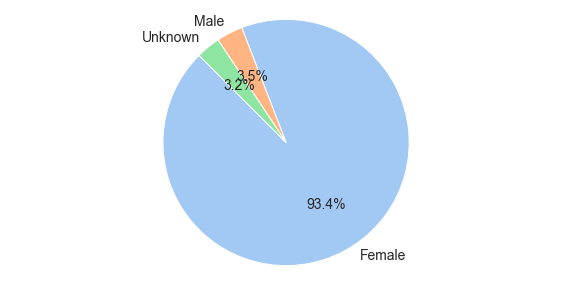

In [13]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
sns.set_style("darkgrid")
df1 = customers['gender'].value_counts()
labels = df1.index
sizes = df1.values / sum(df1.values)
colors = sns.color_palette('pastel')[0:3]
fig, ax = plt.subplots(figsize=(10,5))
ax.pie(sizes, labels=labels, autopct='%1.1f%%', colors= colors,
        shadow=False, startangle=135,textprops={'fontsize': 14})
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax.set_ylabel('Total Spending')
plt.show()

The majority of the customers are female.

In [32]:
np.round(sum(gender_score['gender_metric']==1) / 1362281 * 100,2)

64.29

Customers who only purchase from 'Women' cateogries are around 64% of the whole customers.

### 1.2 What is the average spending by each gender group?

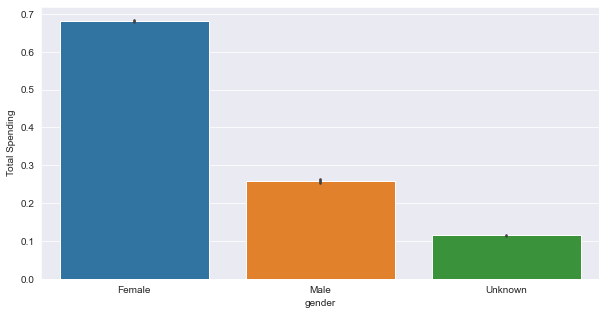

In [33]:
# calculate spending by each customer from transactions table
customers_spending = transactions.groupby('customer_id').price.sum().reset_index()
# add spending by each customer to customers table
customers = pd.merge(customers,customers_spending, how='left', on='customer_id')
# draw barchart
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.barplot(x="gender", y="price", data=customers,order=["Female", "Male","Unknown"], estimator=np.mean)
#ax.set_xticks(np.arange(10,100,10))
ax.set_ylabel('Total Spending')
plt.show()

Female customers tend to spend so much more than male customers in H&M. Female customers' average total spending is 233% higher than that of male customers.\
Female customers are clearly the main customers since they spend more on average than other gender groups and their number account for 93% of the whole customers.

### 1.3 What is the ditribution of customers by age?

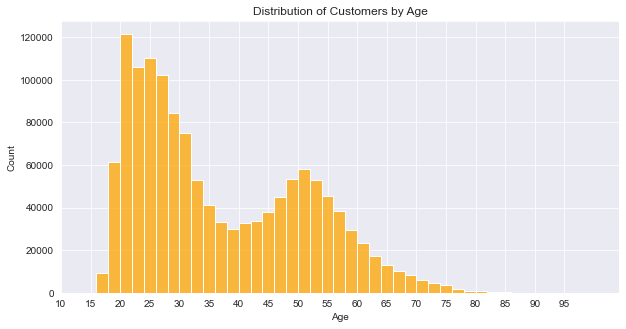

In [54]:
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.histplot(data=customers[['age','gender']].dropna(), x='age', binwidth=2, color='orange')
ax.set_xticks(np.arange(10,100,5))
ax.set_title('Distribution of Customers by Age')
ax.set_xlabel('Age')
plt.show()

Two main groups are identified in the graph. One is between 20 and 30 and another is between 45 and 55.

## 2. Transactions

In [57]:
transactions.groupby('t_dat',as_index=False).count()

t_dat  customer_id  article_id  price  sales_channel_id   year  \
0   2018-09-20        48399       48399  48399             48399  48399   
1   2018-09-21        47543       47543  47543             47543  47543   
2   2018-09-22        17635       17635  17635             17635  17635   
3   2018-09-23        52230       52230  52230             52230  52230   
4   2018-09-24        45984       45984  45984             45984  45984   
..         ...          ...         ...    ...               ...    ...   
729 2020-09-18        39284       39284  39284             39284  39284   
730 2020-09-19        36796       36796  36796             36796  36796   
731 2020-09-20        31489       31489  31489             31489  31489   
732 2020-09-21        32130       32130  32130             32130  32130   
733 2020-09-22        32866       32866  32866             32866  32866   

     month    day  day_name  
0    48399  48399     48399  
1    47543  47543     47543  
2    17635  17635     17635  
3    52230  52230     52230  
4    45984  45984     45984  
..     ...    ...       ...  
729  39284  39284     39284  
730  36796  36796     36796  
731  31489  31489     31489  
732  32130  32130     32130  
733  32866  32866     32866  

[734 rows x 9 columns]

### 2.1 Transaction Trend

In [60]:
df1['customer_id'].nlargest(5)

373    198622
569    162799
435    160875
64     142018
9      141700
Name: customer_id, dtype: int64

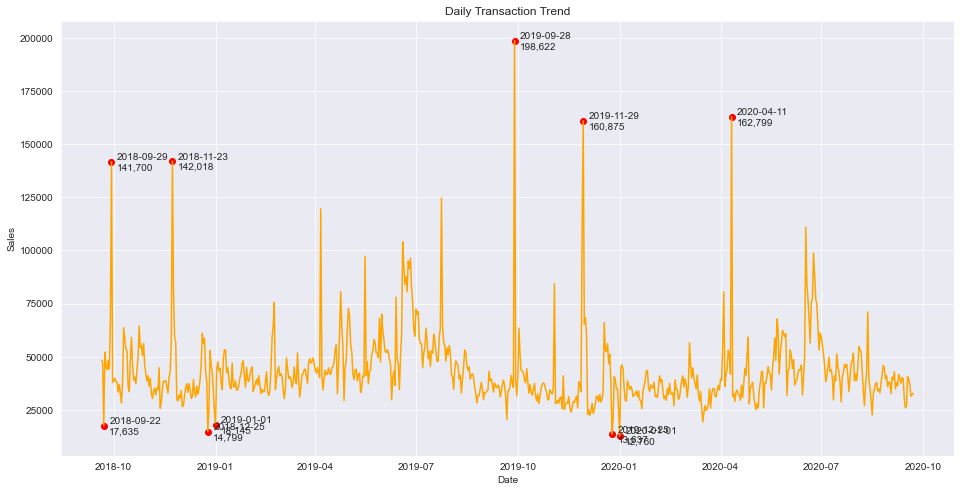

In [64]:
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(16,8))

df1 = transactions.groupby('t_dat',as_index=False).count()
ax = sns.lineplot(data=df1, x='t_dat',y='customer_id', color='orange')
ax.set_title('Daily Transaction Trend')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')

# plot top 5 values
max_5_trans = df1['customer_id'].nlargest(5)
for num in max_5_trans:
    max_date = df1[df1['customer_id']==num]['t_dat']
    ax.scatter(max_date, num, c='red')
    ax.text(max_date+pd.DateOffset(days=5), num-4000, '{}\n{:,d}'.format(max_date.iloc[0].date(), num))

# plot minimum 5 values
min_5_trans = df1['customer_id'].nsmallest(5)
for num in min_5_trans:
    min_date = df1[df1['customer_id']==num]['t_dat']
    ax.scatter(min_date, num, c='red')
    ax.text(min_date+pd.DateOffset(days=5), num-4000, '{}\n{:,d}'.format(min_date.iloc[0].date(), num))
    
# del df1
plt.show()

The number of transactions was particularly higher around the end of September and November. It seems there are regular promotion or marketing campaign around that time.

### 2.2 Online/ Offline Shopping Trend

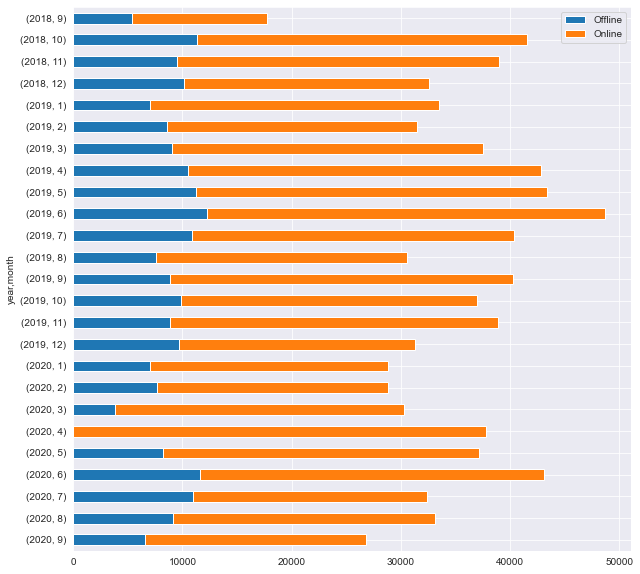

In [68]:
data_plot = transactions[['year','month','sales_channel_id','price']].groupby(['year','month','sales_channel_id']).price.sum()
ax = data_plot.unstack().plot(kind='barh', stacked=True,figsize = (10,10))
ax.invert_yaxis()
ax.legend(['Offline','Online'])
plt.show()

We see seasonality in the sales. The graph shows seasonality but a strong trend.

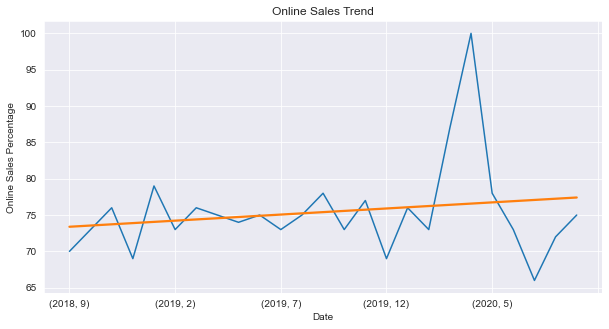

In [69]:
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(10,5))
percentage_online = np.round(transactions[transactions.sales_channel_id == 2].groupby(['year','month']).price.sum() / transactions.groupby(['year','month']).price.sum() * 100).astype('int64')
ax = percentage_online.plot()
sns.regplot(x = np.arange(len(percentage_online.index)),y="price",data=percentage_online.reset_index(),scatter=False,ci=None)
ax.set_title('Online Sales Trend')
ax.set_xlabel('Date')
ax.set_ylabel('Online Sales Percentage')
plt.show()
del data_plot, percentage_online

We see a spike in the graph in April, 2020 which is 100%. It seems that it is due to the COVID lockdown.\
The proportion fluctuates depending on the season, but it is increasing gradually over time.

### 2.3 Basket Analysis : The number of articles purchased in each category

In [70]:
# run this to see the structure of categories.
# df_unique(articles)

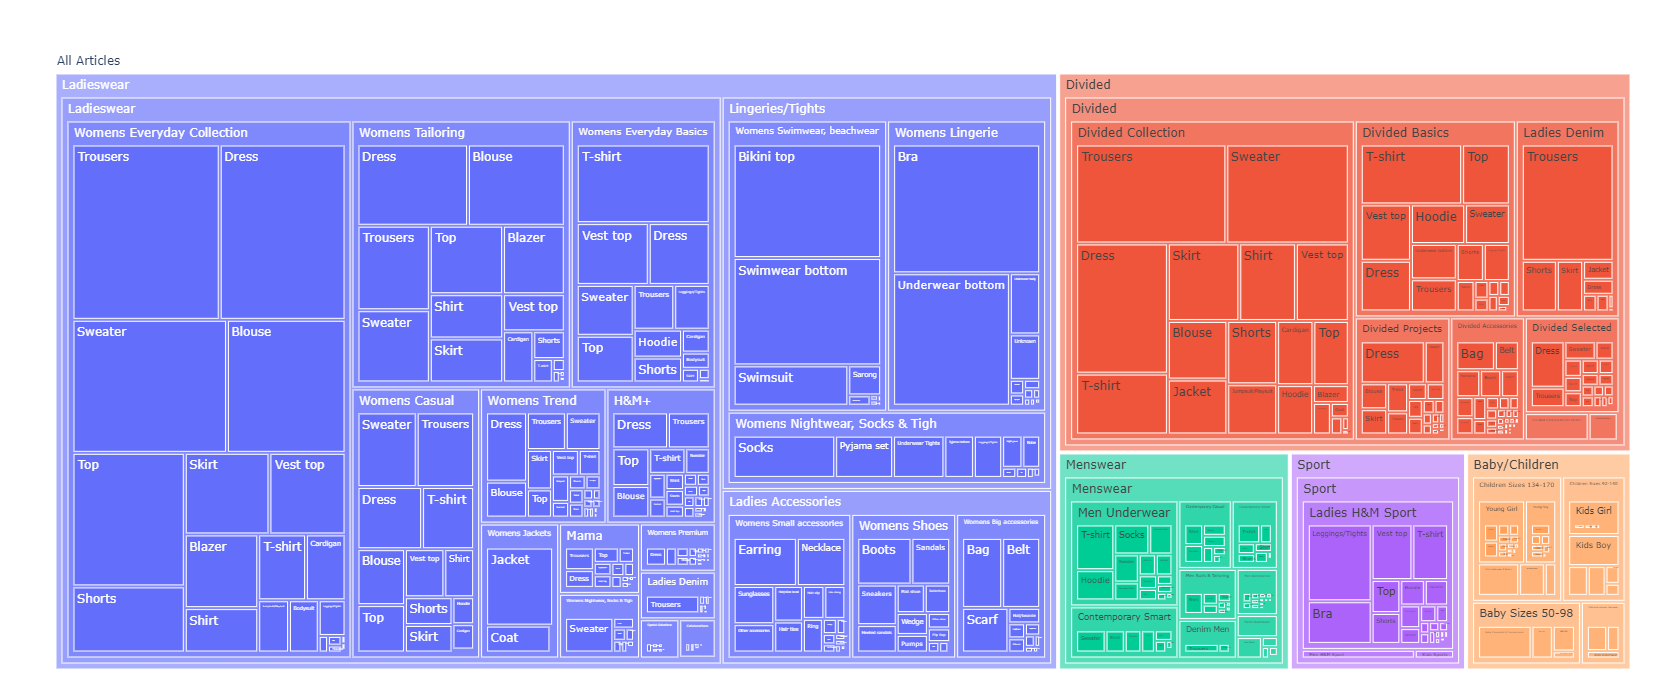

Wall time: 7min 50s


In [71]:
%%time
df1 = transactions_merged.groupby(['index_group_name','index_name','section_name','product_type_name','t_dat','customer_id']).article_id.any().reset_index()
# delete transactions_merged for memory
del transactions_merged
df1.rename({'article_id': 'Percent'}, axis=1, inplace=True)
num_baskets = df1.shape[0]
df1['Percent'] = df1['Percent']/num_baskets * 100
# df1 = reduce_mem_usage(df1)
path_treemap = [px.Constant("All Articles")]+df1.columns.to_list()[:-3]
fig = px.treemap(df1, path=path_treemap, values='Percent', hover_data=['Percent'])
fig.update_layout(margin = dict(t=50, l=50, r=25, b=25),width=1000, height=700)
fig.show()

In [72]:
df1.groupby('index_group_name').Percent.sum().sort_values(ascending=False)

index_group_name
Ladieswear       63.642800
Divided          23.100507
Menswear          5.355990
Sport             4.075891
Baby/Children     3.824812
Name: Percent, dtype: float64

From we can see from the chart and the result abouve. The Ladieswear category accounts for 63.64% of the number of articles bought. Within the category, Trousers, Dress, and Sweater are popular categories. Since Divided category is a brand for young teenage girls, the proprtion of articles purchased in Female category is more than 85.74%. This also confirms that the main customer segment of H&M is Female from teenager girls to adult women.

In [73]:
df1.groupby(['index_group_name','index_name','section_name','product_type_name']).Percent.sum().sort_values(ascending=False).head(10)

index_group_name  index_name        section_name                product_type_name
Ladieswear        Ladieswear        Womens Everyday Collection  Trousers             3.466754
                                                                Dress                2.962301
                  Lingeries/Tights  Womens Lingerie             Bra                  2.898366
                  Ladieswear        Womens Everyday Collection  Sweater              2.759707
                  Lingeries/Tights  Womens Swimwear, beachwear  Bikini top           2.562496
                                                                Swimwear bottom      2.422939
                                    Womens Lingerie             Underwear bottom     2.364754
Divided           Divided           Divided Collection          Trousers             2.250717
Ladieswear        Ladieswear        Womens Everyday Collection  Blouse               2.118198
                                                                Top     

7 of top 10 most popular product categories are in Ladieswear. Womens Everyday Collection is the most popular category and Trousers are the most popular product type. \
Another interesting finding is that more than 1/3 of purchases of Menswear belong to Underwear. Clearly the shopping patterns between Women and Men are different.

### 2.3.1 Are shopping patterns in offline and online channel different?

In [74]:
# recreate transactions_merged dataframe
transactions_merged = pd.merge(transactions, articles,how='left',on='article_id')

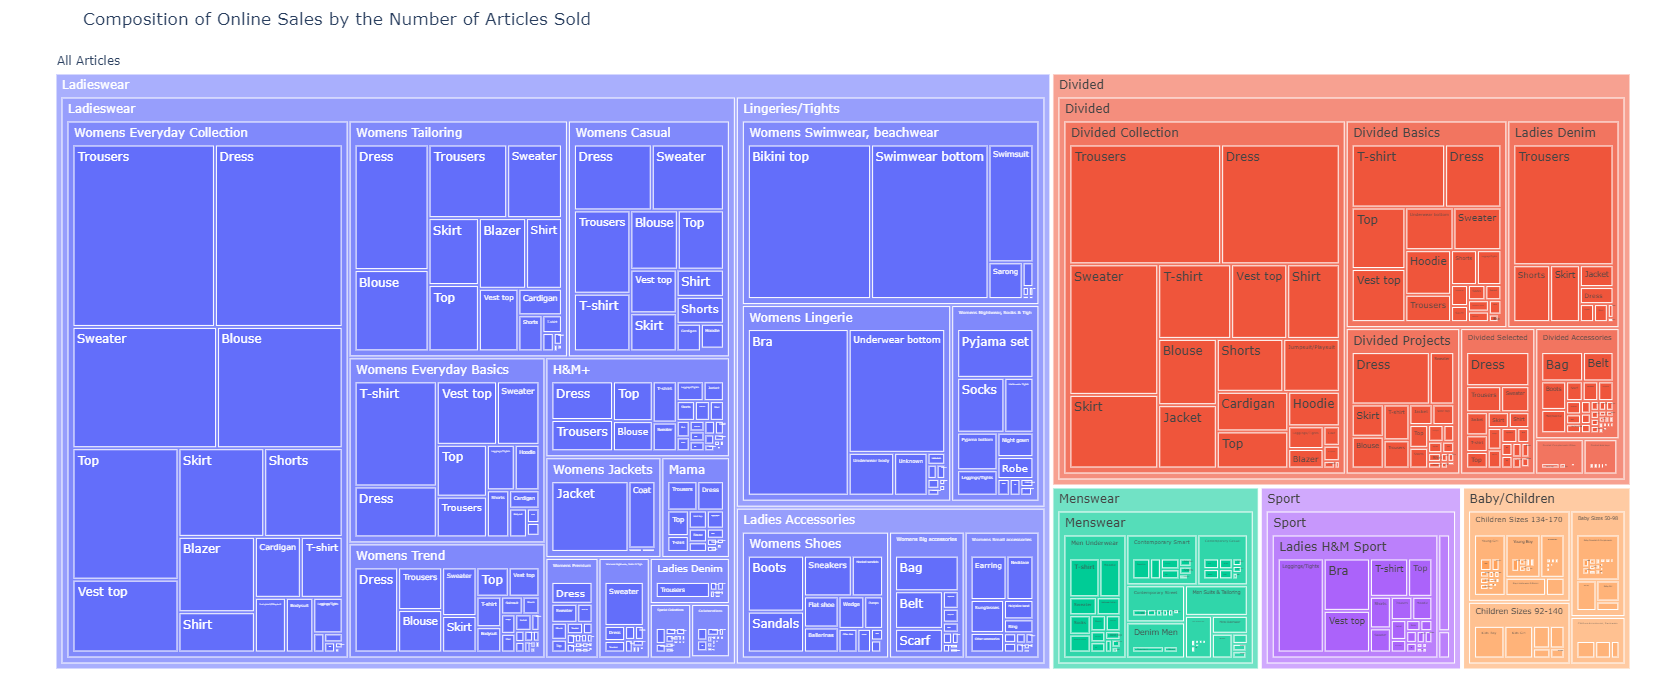

In [75]:
# Online Treemap
# delete df1 to save memory
## del df1
df1 = transactions_merged.loc[transactions_merged['sales_channel_id']==2].groupby(['index_group_name','index_name','section_name','product_type_name','t_dat','customer_id']).article_id.any().reset_index()
# deleted transactions_merged for memory
del transactions_merged
df1.rename({'article_id': 'Percent'}, axis=1, inplace=True)
num_baskets = df1.shape[0]
df1['Percent'] = df1['Percent']/num_baskets * 100
# df1 = reduce_mem_usage(df1)
path_treemap = [px.Constant("All Articles")]+df1.columns.to_list()[:-3]
fig = px.treemap(df1, path=path_treemap, values='Percent', hover_data=['Percent'])
fig.update_layout(margin = dict(t=50, l=50, r=25, b=25),width=1000, height=700, title_text='Composition of Online Sales by the Number of Articles Sold')
fig.show()

In [76]:
df1.groupby('index_group_name').Percent.sum().sort_values(ascending=False)

index_group_name
Ladieswear       63.216583
Divided          25.465470
Menswear          4.064181
Sport             3.947747
Baby/Children     3.306018
Name: Percent, dtype: float64

In [77]:
df1.groupby(['index_group_name','index_name','section_name','product_type_name']).Percent.sum().sort_values(ascending=False).head(10)

index_group_name  index_name        section_name                product_type_name
Ladieswear        Ladieswear        Womens Everyday Collection  Trousers             3.490887
                                                                Dress                3.129444
                  Lingeries/Tights  Womens Swimwear, beachwear  Bikini top           3.005701
                                                                Swimwear bottom      2.863816
Divided           Divided           Divided Collection          Trousers             2.683720
Ladieswear        Lingeries/Tights  Womens Lingerie             Bra                  2.666537
                  Ladieswear        Womens Everyday Collection  Sweater              2.355870
Divided           Divided           Divided Collection          Dress                2.097419
                                    Ladies Denim                Trousers             2.047826
Ladieswear        Ladieswear        Womens Everyday Collection  Blouse  

The composition of Online purchases is similar to total purchases, but the proportion of Divided category is bigger. Since the main customers of Divided category are teenagers and younger customers, it shows that the younger customers prefer online shopping.

In [78]:
transactions_merged = pd.merge(transactions, articles,how='left',on='article_id')

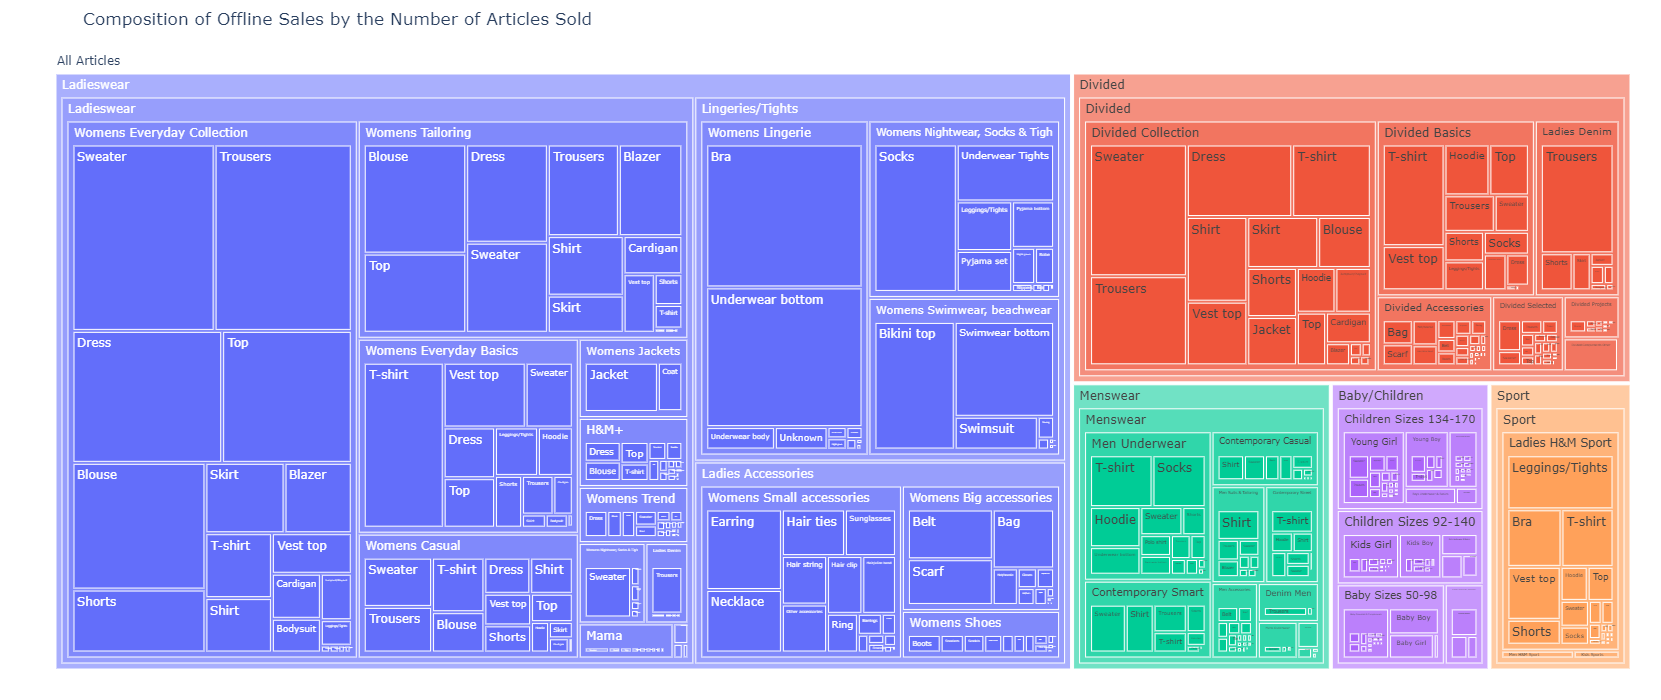

In [79]:
#Offline Treemap
del df1
df1 = transactions_merged.loc[transactions_merged['sales_channel_id']==1].groupby(['index_group_name','index_name','section_name','product_type_name','t_dat','customer_id']).article_id.any().reset_index()
# deleted transactions_merged for memory
del transactions_merged
df1.rename({'article_id': 'Percent'}, axis=1, inplace=True)
num_baskets = df1.shape[0]
df1['Percent'] = df1['Percent']/num_baskets * 100
# df1 = reduce_mem_usage(df1)
path_treemap = [px.Constant("All Articles")]+df1.columns.to_list()[:-3]
fig = px.treemap(df1, path=path_treemap, values='Percent', hover_data=['Percent'])
fig.update_layout(margin = dict(t=50, l=50, r=25, b=25),width=1000, height=700,title_text='Composition of Offline Sales by the Number of Articles Sold')
fig.show()

In [80]:
df1.groupby('index_group_name').Percent.sum().sort_values(ascending=False)

index_group_name
Ladieswear       64.525606
Divided          18.437204
Menswear          7.878793
Baby/Children     4.832624
Sport             4.325773
Name: Percent, dtype: float64

In [81]:
df1.groupby(['index_group_name','index_name','section_name','product_type_name']).Percent.sum().sort_values(ascending=False).head(10)

index_group_name  index_name        section_name                    product_type_name
Ladieswear        Ladieswear        Womens Everyday Collection      Sweater              3.556393
                                                                    Trousers             3.432507
                  Lingeries/Tights  Womens Lingerie                 Bra                  3.357693
                                                                    Underwear bottom     3.281637
                  Ladieswear        Womens Everyday Collection      Dress                2.651948
                                                                    Top                  2.296239
                                                                    Blouse               2.262146
Divided           Divided           Divided Collection              Sweater              2.073565
Ladieswear        Ladieswear        Womens Everyday Basics          T-shirt              2.003261
                  Lingeries/Tigh

Comparing online and offline shopping patterns, there are some findings:
- Younger customers prefer online shopping. The proportion of Divided is much bigger of which the main customer is young customers. They tend to buy Divided-Trousers much more online, while they buy Sweater online and offline.
- Customers buy more sweaters offline. The proportions of Sweater categories in different indices are higher. It seems that customers want to see them and try them before buying them.
- Basic T-shirt and Socks are more purchased in offline channel. Both categories have low price range. It seems that customers are tempted to buy them when they visit stores to buy other articles because of its low price point.

## 3. Conclusion


The 3 datasets contain vast amount of interesting information. We understood the distribution of the customers and specified the main customer segment. We understood the trend of purchase transactions. We saw patterns of transactions fluctuation and seasonality. Also, though there are more online transactions and the proportion is increasing, the trend is not so strong. Lastly, we understood the composition of transactions in terms of the number of articles sold. Ladies clothings are the most popular categories. Also the purchase patterns in online and offline were different.\
These findings will be useful for building recommendation model in the future.